In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

In [3]:
def MX_plus():

    g = jqt.basis(2,0)
    e = jqt.basis(2,1)
    plus = (g + e).unit()
    pp = plus @ plus.dag()
    kmap = jqt.QarrayArray.create([2*pp])

    return jqtc.Gate.create(
        2, 
        name="MXplus",
        gen_KM = lambda params: kmap,
        num_modes=1
    )

In [4]:
def run_circuit(params):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas = params[2]
    
    N = 30
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    cirq.append(MX_plus(), 0)

    initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
    res = jqtc.simulate(cirq, initial_state, mode="kraus")

    return res[-1][-1].unit()

Text(62.44444444444453, 0.5, 'Im[α]')

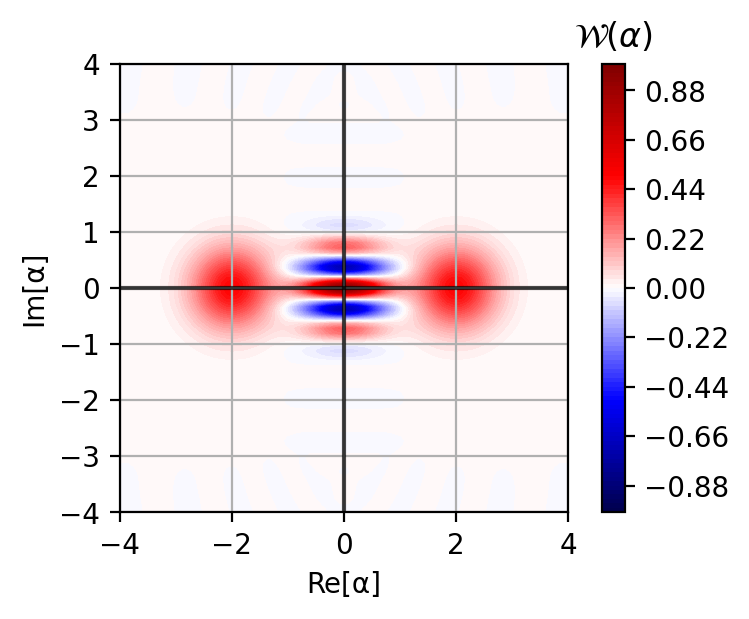

In [5]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0]])

final_state = run_circuit(
    params
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

Text(62.44444444444453, 0.5, 'Im[α]')

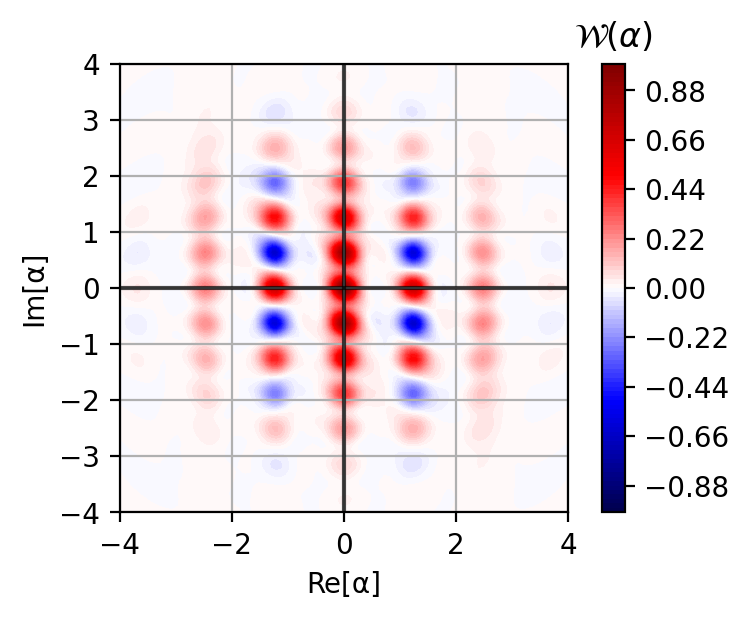

In [6]:
gkp_qubit = jqtb.GKPQubit({"delta": 0.3, "N": 30})
target_state = gkp_qubit.basis["+z"]
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

In [7]:
def fid_metric(params):
    N = 30
    prepared_state = jqt.ptrace(run_circuit(params),1)
    return jnp.real(jqt.overlap(target_state, prepared_state).data[0][0])

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0,))

def metric(params):
    fids = fid_metric_vmap(params)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

metric(jnp.array([params,2*params]))

Array(-0.08402273, dtype=float64)

# Batch Gradient Descent

In [ ]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Parameters
key = jax.random.PRNGKey(0)  # Initialize a random key
B = 100 # Batch size
num_blocks = 6
lower_bounds = jnp.array([-1, -1, -20])  # Define the lower bounds for each axis
upper_bounds = jnp.array([1, 1, 20])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 3, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params)

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params)

In [9]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = 200
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params))
  metric, grads = metric_val_and_grad(params)
  metric_history.append(metric)

  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metric:.4f}, best fid = {jnp.max(fids_history[-1])}")

  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

params_history = jnp.array(params_history)
fids_history = jnp.array(fids_history)
metric_history = jnp.array(metric_history)

  0%|          | 1/200 [00:04<15:41,  4.73s/it]

Epoch 0: metric = -0.0794, best fid = 0.347202680976252


  6%|▌         | 11/200 [00:55<15:54,  5.05s/it]

Epoch 10: metric = -0.2911, best fid = 0.5648558445021241


 10%|█         | 21/200 [02:04<18:19,  6.14s/it]

Epoch 20: metric = -0.4223, best fid = 0.5684047803891265


 16%|█▌        | 31/200 [03:02<15:36,  5.54s/it]

Epoch 30: metric = -0.5173, best fid = 0.626258769153189


 20%|██        | 41/200 [04:03<16:31,  6.23s/it]

Epoch 40: metric = -0.5890, best fid = 0.6594481440249116


 26%|██▌       | 51/200 [04:57<12:57,  5.22s/it]

Epoch 50: metric = -0.6699, best fid = 0.7357182642608021


 30%|███       | 61/200 [05:48<10:56,  4.72s/it]

Epoch 60: metric = -0.7363, best fid = 0.7584433916708491


 36%|███▌      | 71/200 [06:30<09:18,  4.33s/it]

Epoch 70: metric = -0.7973, best fid = 0.7790475636053137


 40%|████      | 81/200 [07:13<08:32,  4.30s/it]

Epoch 80: metric = -0.8473, best fid = 0.7898684791551592


 46%|████▌     | 91/200 [07:56<07:43,  4.26s/it]

Epoch 90: metric = -0.8878, best fid = 0.7943593038797686


 50%|█████     | 101/200 [08:46<07:59,  4.84s/it]

Epoch 100: metric = -0.9251, best fid = 0.8008737620497216


 56%|█████▌    | 111/200 [09:28<06:15,  4.21s/it]

Epoch 110: metric = -0.9677, best fid = 0.7985479480903913


 60%|██████    | 121/200 [10:11<05:41,  4.33s/it]

Epoch 120: metric = -0.9887, best fid = 0.8016685729532257


 62%|██████▎   | 125/200 [10:50<06:30,  5.20s/it]


KeyboardInterrupt: 

In [11]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

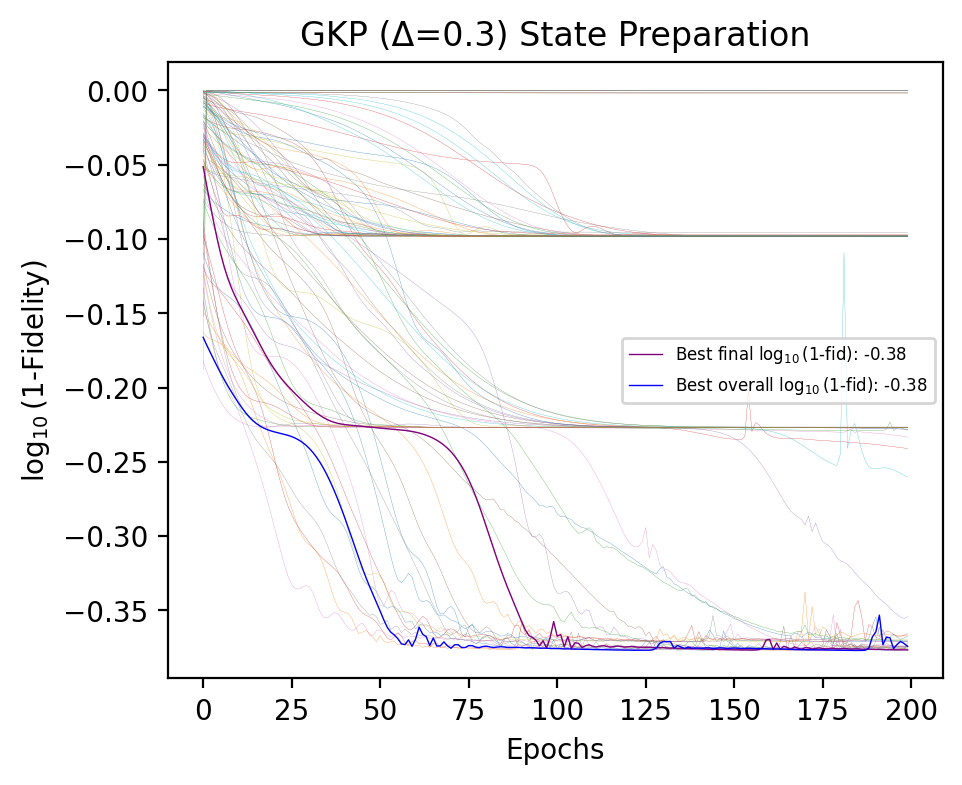

In [19]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

Best parameters: 
 [[ 1.00057951 -0.99991071]
 [ 1.23616652  0.51308931]
 [ 8.41736869  8.41725676]]


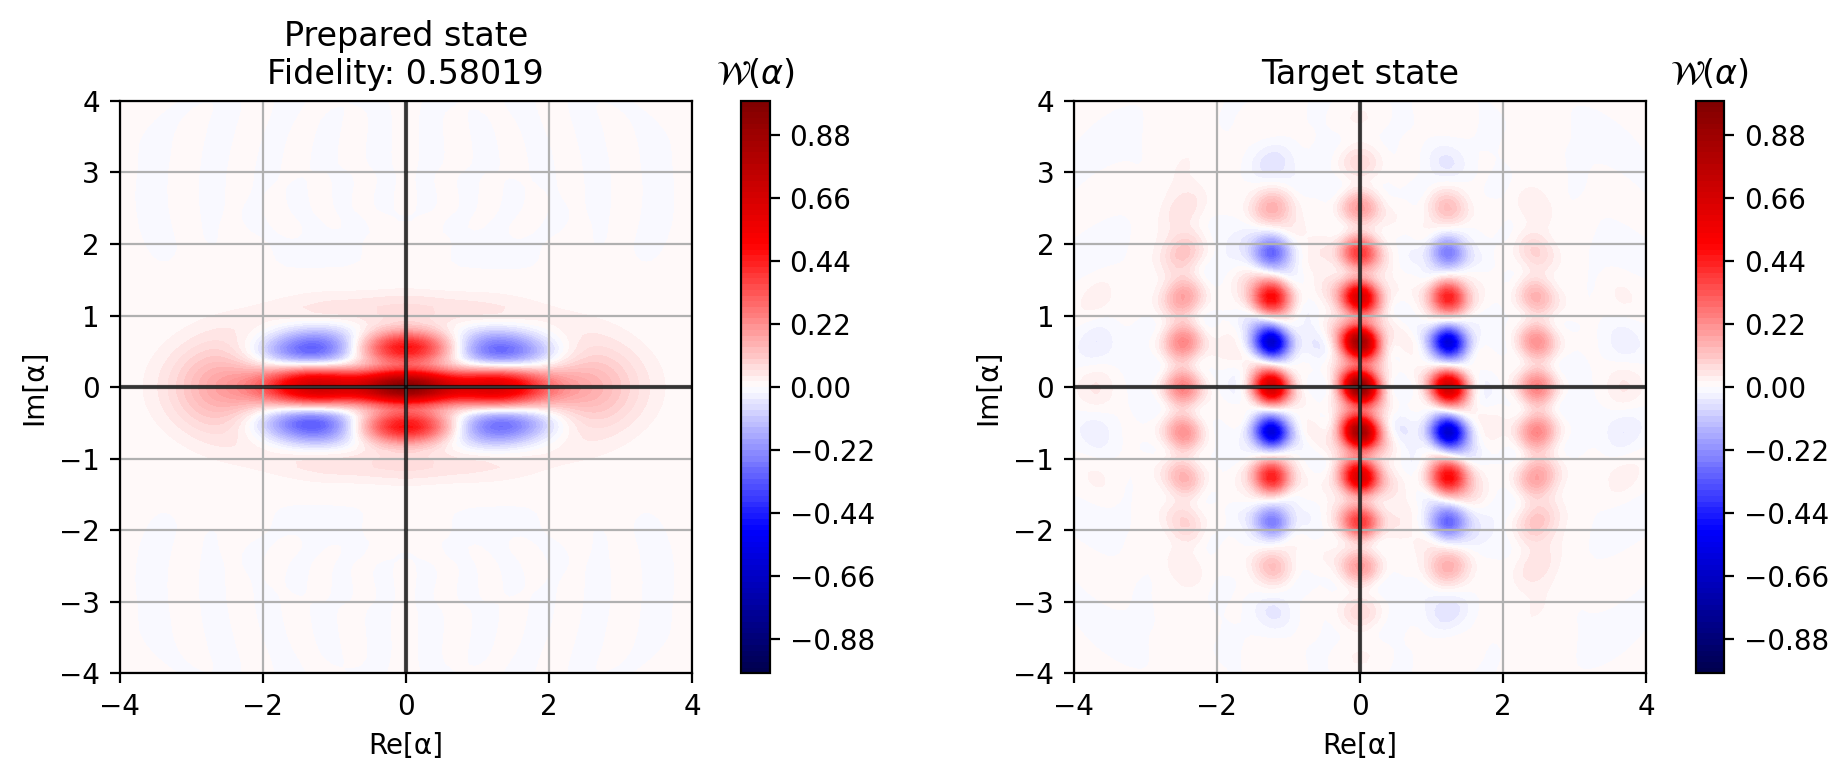

In [15]:
best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
print("Best parameters: \n", best_params)


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

state = run_circuit(best_params)
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"Fidelity: {best_fid:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()

Array(0.3, dtype=float64, weak_type=True)